### Copyright Matlantis Corp. as contributors to Matlantis contrib project

[EN]
## Evaluation of Polymer Adhesion to a Surface
- This notebook is an implementation based on [the following paper](https://pubs.acs.org/doi/10.1021/acs.langmuir.5c03183)(K. Kudo and Y. Sumiya, Langmuir (2025)).
- In this notebook, we will evaluate the adhesive strength.

In [1]:
import io
import matplotlib.pyplot as plt
import numpy as np
import optuna
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings('ignore')

from ase import units
from ase.io import read

from pfcc_extras import show_gui
import pfp_api_client
from pfp_api_client.pfp.calculators.ase_calculator import ASECalculator
from pfp_api_client.pfp.estimator import Estimator, EstimatorCalcMode


def calc_energy_curve(atoms, calculator, n_steps=40, step_size=0.2):

    """
    Calculates the potential energy curve by systematically displacing a group of atoms.

    Parameters:
        atoms (ase.Atoms): The initial ASE Atoms object. It must contain atoms
                           with `tag=2`, which will be the group to be displaced.
        calculator (ase.calculators.calculator.Calculator): An ASE calculator
                                                            to compute the energy.
        n_steps (int, optional): The total number of displacement steps.
                                 Defaults to 40.
        step_size (float, optional): The displacement distance for each step in
                                     Angstroms. Defaults to 0.2.

    Returns:
        tuple: A tuple containing two lists:
            - displacements (list of float): The total displacement at each step (in Angstroms).
            - relative_energies (list of float): The potential energy at each step,
                                                 relative to the initial energy (in eV).
    """
    
    atoms_copy = atoms.copy()
    atoms_copy.calc = calculator
    
    # Lists to store the results
    displacements = []
    potential_energies = []
    
    # Get the indices of atoms with tag=2 beforehand
    indices_to_move = [atom.index for atom in atoms_copy if atom.tag == 2]
    
    for i in range(n_steps):
        # Calculate the potential energy of the current system
        energy = atoms_copy.get_potential_energy()
        
        # Calculate the current total displacement
        total_displacement = i * step_size
        
        # Append the results to the lists
        displacements.append(total_displacement)
        potential_energies.append(energy)
        
        # Move the group of atoms with tag=2 by step_size in the z-direction
        displacement_vector = np.array([0.0, 0.0, step_size])
        atoms_copy.positions[indices_to_move] += displacement_vector
    
    initial_energy = potential_energies[0]
    relative_energies = [energy - initial_energy for energy in potential_energies]
    return displacements, relative_energies

def morse_potential(delta_r, E_ad, a):
    return E_ad * (1 - np.exp(-a * delta_r))**2

In [2]:
model_version="v8.0.0"
calc_mode = "PBE_PLUS_D3"

# Path to the output folder from notebook 01
outpath = "output/mp-81"

In [3]:
# read adsorption structure
storage = optuna.storages.JournalStorage(
    optuna.storages.JournalFileStorage(outpath+"/optuna_study.log"),)
study = optuna.load_study(study_name='study',storage=storage)
atoms = read(io.StringIO(study.best_trial.user_attrs["structure"]), format="json")
show_gui(atoms, representations=["ball+stick"])

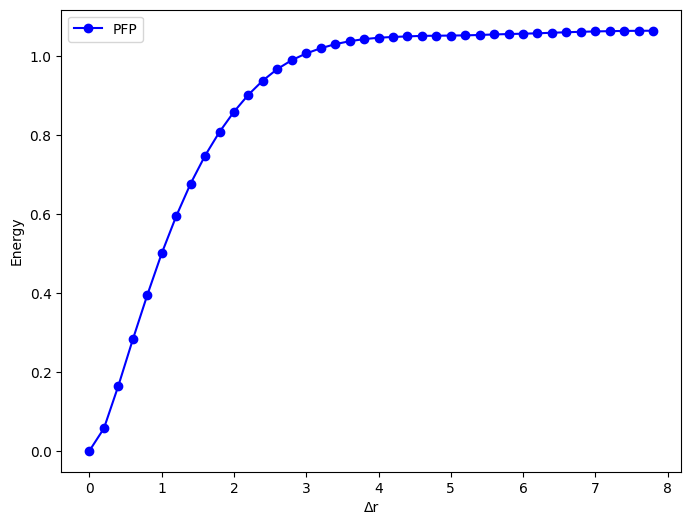

In [4]:
# create calculator
estimator = Estimator(calc_mode=calc_mode, model_version=model_version)
calculator = ASECalculator(estimator)

# calc energy curve
displacements, relative_energies = calc_energy_curve(atoms, calculator)

plt.figure(figsize=(8, 6))
plt.plot(displacements, relative_energies, 'o-', color="blue", label="PFP")
plt.xlabel('Δr')
plt.ylabel('Energy')
plt.legend()
plt.show()

In [5]:
# Fit the energy curve using Morse potential.
params, _ = curve_fit(
    morse_potential,
    displacements,
    relative_energies,
    )

print(f"E_ad: {params[0]}")
print(f"a: {params[1]}")

E_ad: 1.0637471806450485
a: 1.1623577267450056


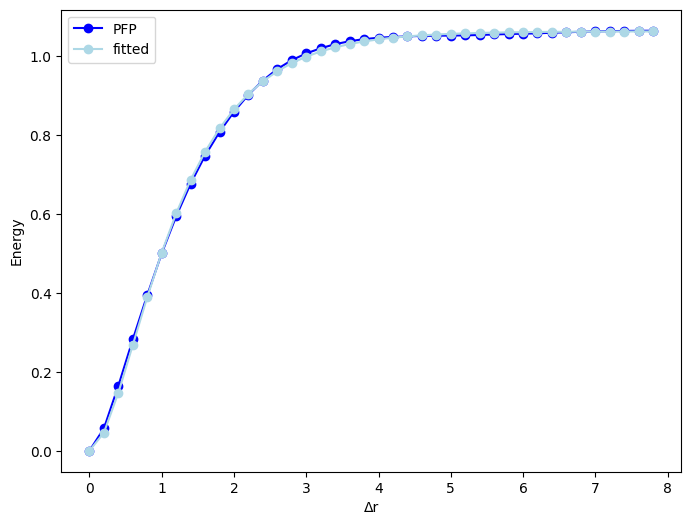

In [6]:
fitted_values = [morse_potential(displacement, params[0], params[1]) for displacement in displacements ]

plt.figure(figsize=(8, 6))
plt.plot(displacements, relative_energies, 'o-', color="blue", label="PFP")
plt.plot(displacements, fitted_values, 'o-',color="lightblue", label="fitted")
plt.xlabel('Δr')
plt.ylabel('Energy')
plt.legend()
plt.show()

In [7]:
# calc cell area
cell_vectors = atoms.get_cell()
a_vec = cell_vectors[0]
b_vec = cell_vectors[1]
cross_product = np.cross(a_vec, b_vec)
area = np.linalg.norm(cross_product)

In [8]:
# Calculate adhesive strength according to Eq. (3) in the paper.
S_ad = params[1] * params[0]/(2*area) / units.GPa * 1000
print(f"S_ad: {S_ad}")

S_ad: 365.1867602104724


In [9]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sat Oct 18 2025

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 9.4.0

pfcc_extras   : 0.12.0
numpy         : 1.26.0
ase           : 3.25.0
scipy         : 1.13.1
pfp_api_client: 1.24.0
matplotlib    : 3.9.0
optuna        : 4.5.0

Watermark: 2.5.0

